# Transfer Learning from PatchCore to Linear Regression
The following document will attempt a solutiont to abstract PatchCore away in order to hide the memory bank.  
By hiding the memory bank, we become able to use HomoMorphic Encryption on the model.

**This document follows these steps:**
1. Train PatchCore on half the dataset **dataset_a** -> result: patchCore model (**ModelA**)
2. Evaluate the resulting model (we care about AUROC)
3. Use **modelA** to add labels (*anomaly scores*)to all patches within the images in **dataset_b** -> **annotated_dataset_b**.
4. Use annotated_dataset_b to train a LinearRegression model **ModelB**
5. With ModelB, estimate patch scores for test data patches.
6. Test the model effictiveness of ModelB.
7. Conclusion on the performance of ModelB

## (1) Training PatchCore

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from pytorch_lightning import Trainer, seed_everything

from config import get_configurable_parameters
from data import get_datamodule
from models import get_model
from utils.callbacks import LoadModelCallback, get_callbacks

# config
config = get_configurable_parameters(model_name="patchcore", config_path="config.yaml")
if config.project.get("seed") is not None:
    seed_everything(config.project.seed)

# prepare dataomdule
datamodule = get_datamodule(config)

# prepare model
model = get_model(config)
callbacks = get_callbacks(config)

# fit the model
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PatchcoreModel           | 24.9 M
3 | image_metrics         | AnomalibMetric

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## (2) Evaluate the resulting model model_a

In [4]:
trainer.test(model=model, datamodule=datamodule)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9715957045555115
      image_F1Score         0.9642857909202576
       pixel_AUROC          0.9759382605552673
      pixel_F1Score          0.369069367647171
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'pixel_F1Score': 0.369069367647171,
  'pixel_AUROC': 0.9759382605552673,
  'image_F1Score': 0.9642857909202576,
  'image_AUROC': 0.9715957045555115}]

## (3) Annotate dataset_b

In [5]:
import json
import torch

from inferencer import TorchInferencer
from data.utils import get_image_filenames, read_image


inferencer = TorchInferencer(
    config=config,
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
    device="auto"
)
model = inferencer.model.model
filenames = get_image_filenames(path="datasets/MVTec_b/grid/")

dataset_b_annotated = {
    "threshold": None,
    "images": []
}
print("Starting to process images...")
for filename in filenames:
    image_arr = read_image(filename)

    metadata = inferencer.metadata
    metadata["image_shape"] = image_arr.shape[:2]
    processed_image = inferencer.pre_process(image_arr)

    # generating embeddings
    with torch.no_grad():
        features = model.feature_extractor(processed_image)
    features = {layer: model.feature_pooler(feature) for layer, feature in features.items()}
    embedding = model.generate_embedding(features)
    batch_size, _, width, height = embedding.shape
    embedding = model.reshape_embedding(embedding)

    # calculating anomaly score / patch
    patch_scores, _ = model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    
    dataset_b_annotated["images"].append({
        "filename": filename.name,
        "embedding": embedding.tolist(),
        "patch_scores": patch_scores.tolist(),
    })
    if len(dataset_b_annotated['images']) % 10 == 0:
        print(f"Finished {len(dataset_b_annotated['images'])} out of {len(filenames)} images")

print(f"inference finished for {len(filenames)} images")

Starting to process images...
Finished 10 out of 131 images
Finished 20 out of 131 images
Finished 30 out of 131 images
Finished 40 out of 131 images
Finished 50 out of 131 images
Finished 60 out of 131 images
Finished 70 out of 131 images
Finished 80 out of 131 images
Finished 90 out of 131 images
Finished 100 out of 131 images
Finished 110 out of 131 images
Finished 120 out of 131 images
Finished 130 out of 131 images
inference finished for 131 images


## (4) Train the LR model

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [7]:
# preparing data 
x, y = [], []

for image in dataset_b_annotated['images']:  # flattening data into X, and Y
    x = x + image['embedding']
    y = y + image['patch_scores']

# training the model
lr_model = LinearRegression()
lr_model.fit(x,y)

LinearRegression()

## (5) Evaluating the LR model on input data

In [11]:
# testing the model
from sklearn.metrics import r2_score, mean_squared_error

# Use the model to make predictions
y_predicted = lr_model.predict(x)

# Compute R-squared and RMSE scores
r2 = r2_score(y, y_predicted)
print('R-squared score: ', r2)
rmse = mean_squared_error(y, y_predicted, squared=False)
print(f"RMSE: {rmse}")

R-squared score:  0.7106090168414771
RMSE: 1.7853186705915187


## (6) Testing PatchCore anomaly scoring performance against our new linear regression model

### Steps 
1. Prepare the dataset to be used. This is a list of embeddings for all images in the dataset
2. Run PatchCore on the given dataset and store the resulting patch score values in an array
3. Run the same dataset on the LR model, and store the results
4. Plot both numbers against each other

Question: What exactly should we plot?
We need a good metric to measure the deviation of the LR results from the patchCore results.

In [8]:
## step1 - prepare the test dataset
import torch

from data.utils import get_image_filenames, read_image
from inferencer import TorchInferencer
from post_processing import Visualizer

filenames = get_image_filenames(path="datasets/MVTec_a/grid/test")

inferencer = TorchInferencer(
    config="config.yaml",
    model_source="output/results/patchcore/mvtec/grid/run/weights/lightning/model.ckpt",
)
patchcore_model = inferencer.model.model

metadata = getattr(inferencer, "metadata")

embeddings = []
for filename in filenames:
    image_arr=read_image(filename)
    metadata["image_shape"] = image_arr.shape[:2]

    processed_image = inferencer.pre_process(image_arr)

    with torch.no_grad():
        features = patchcore_model.feature_extractor(processed_image)  # 2nd and 3rd layer
    
    features = {layer: patchcore_model.feature_pooler(feature) for layer, feature in features.items()}
    embedding = patchcore_model.generate_embedding(features)

    batch_size, _, width, height = embedding.shape
    embedding = patchcore_model.reshape_embedding(embedding)
    embeddings.append(embedding)

len(embeddings)

78

In [9]:
## step 2 - patch score results
### patchcore results for the given 78 images flattened
patchcore_results = []
for embedding in embeddings:
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_results += patch_scores_patchcore
len(patchcore_results)

61152

In [10]:
## step 3 - LR results
### LR model results for the given 78 images
lr_results = []
for embedding in embeddings:
    patch_scores_lr_model = lr_model.predict(embedding).tolist()
    lr_results += patch_scores_lr_model
len(lr_results)

61152

In [47]:
import matplotlib.pyplot as plt


def draw_two_plots(y1, y2, y_axis="Anomaly Score", title="PatchCore vs LinearRegression"):
    fig, ax = plt.subplots()
    
    ax.plot(y1, color='red', label="patchCore")
    ax.plot(y2, color='blue', label="Linear Regression")
    
    # Add labels and title
    ax.set_ylabel('Anomaly Score')
    ax.set_title('PatchCore vs LinearRegression (on patch level)')
    ax.legend()
    plt.show()

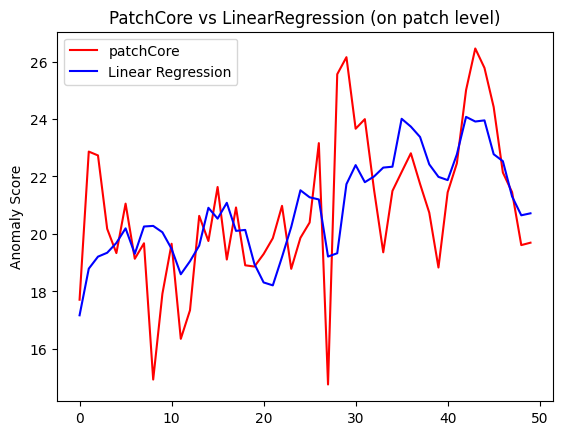

In [48]:
draw_two_plots(patchcore_results[:50], lr_results[:50])


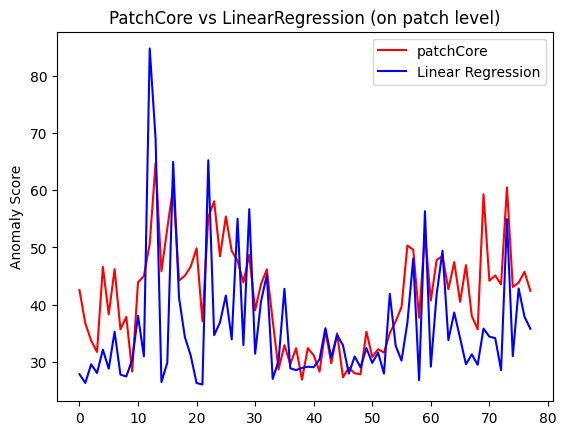

In [49]:
# Measuring the image-level anomaly scores deviation

patchcore_image_results = []
for embedding in embeddings:  # We use the Max function to determine the image patch score
    patch_scores_patchcore, _ = patchcore_model.nearest_neighbors(embedding=embedding, n_neighbors=1)
    patchcore_image_results.append(max(patch_scores_patchcore))
len(patchcore_image_results)

lr_image_results = []
for embedding in embeddings:
    patch_scores_lr_model = lr_model.predict(embedding).tolist()
    lr_image_results.append(max(patch_scores_lr_model))
len(lr_image_results)

draw_two_plots(patchcore_image_results, lr_image_results, title='PatchCore vs LinearRegression (on Image Level)')

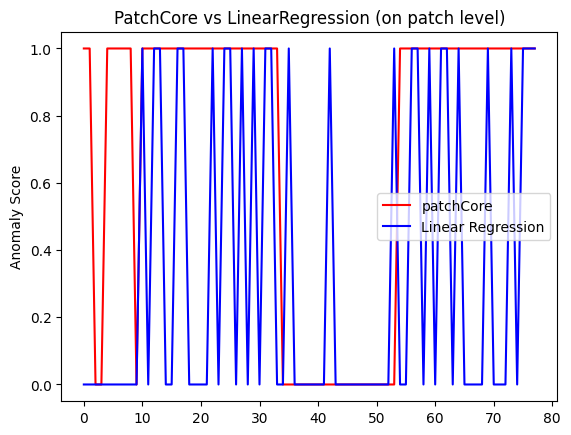

In [50]:
# Measuring the image-level classification deviation
threshold = inferencer.metadata["image_threshold"]

patchcore_image_results_class = [1 if res > threshold else 0 for res in patchcore_image_results]
lr_image_results_class        = [1 if res > threshold else 0 for res in lr_image_results]

draw_two_plots(patchcore_image_results_class, lr_image_results_class, title='PatchCore vs LinearRegression classification')

In [38]:
sum(patchcore_image_results_class), sum(lr_image_results_class)

(55, 26)

## Conclusion

The Linear Regression model doesn't do a good job following the PatchCore results.

Adjusting the threshold might be a good way to improve the model,  
but given that the difference between the two models is not a linear bias, we can assume that changing the threshold will not give us a perfect model. 

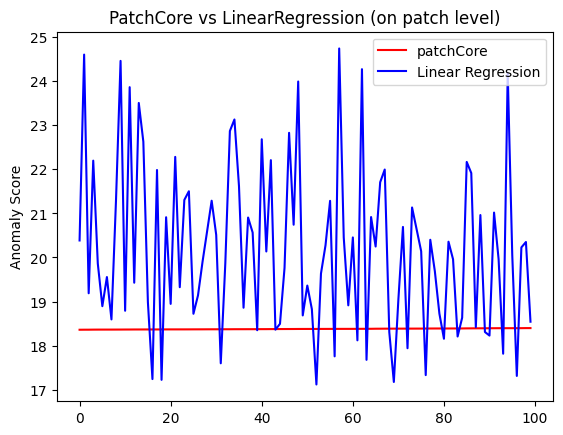

In [62]:
# Clearly show the deviation by ordering the patchCore results by lowest to highest

# this line creates a list of pairs of (patchcore result, LR result) for each patch
y12 = [(patchcore_results[i], lr_results[i]) for i in range(len(patchcore_results))]

# we sort by patchcore result from lowest to highest - while keeping the second element to the LR value
y12 = sorted(y12, key=lambda x: x[0])

# we split again patchcore (y1) from Linear Regression (y2) so we can plot them
y1 = [x[0] for x in y12]
y2 = [x[1] for x in y12]
draw_two_plots(y1[4000:4100], y2[4000:4100], lr_results)